In [1]:
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import neurokit2 as nk
import warnings
warnings.filterwarnings('ignore')

# set global parameters
# mpl.rcParams['pdf.fonttype'] = 42
# mpl.rcParams['ps.fonttype'] = 42
# mpl.rcParams['font.family'] = 'Arial'
# mpl.style.use("ggplot") # selecting the style sheet

from lists import dyads, num_dyads, participants, num_participants
from math import pi, cos

In [2]:
# Set sampling rate
sampling_rate = 1000
print("Sampling rate:", sampling_rate)

# Set conditions
conditions = ["sit","gaze"]
print("Conditions:", conditions)

# Show number of participants
print("Participants:", num_participants)

# Show number of dyads
print("Dyads:", num_dyads)

Sampling rate: 1000
Conditions: ['sit', 'gaze']
Participants: 8
Dyads: 4


In [3]:
xlim1 = 10*sampling_rate
xlim2 = 14*sampling_rate

dpi = 96
figsize = 7, 3

mpl.rcParams["legend.frameon"] = True
mpl.rcParams["legend.fancybox"] = False
mpl.rcParams["legend.framealpha"] = 0.9
mpl.rcParams["legend.edgecolor"] = "darkgrey"

con = "gaze"  # condition
d = 2  # dyad -> only even numbers
p = 6  # person

In [4]:
# Load ECG data
ecg_raw_2000hz = {}
ecg_raw = {}


for con in conditions:
    ecg_raw_2000hz[con] = np.load(f"data/ecg_raw/ecg_raw_{con}.npy")
    # Change sampling rate to 1000 Hz
    ecg_raw[con] = [
        ecg_raw_2000hz[con][i][::2] 
        for i in participants
    ]
    
# Analyze raw ECG data
ecg_process = {}
ecg = {}

for con in conditions:
    ecg_process[con] = [
        nk.ecg_process(
            ecg_raw[con][i],
            sampling_rate=sampling_rate)
        for i in participants
    ]
    
    ecg[con] = [
        ecg_process[con][i][0]["ECG_Clean"]
        for i in participants
    ]

# Show some data
# display(ecg_process["gaze"][p][0])


In [5]:
# Functions for preprocessing

# 
def get_ibi_timeseries(rpeaks, ibi, start, begin_at_0):
    """Generates pd.Series based on binary r-peak time series, where y = 1 is changed \
        to the corresponding IBI and y = 0 remains unchanged.\n
        Used for the tachogram and the basis for linear interpolation of IBI data. 

    Args:
        rpeaks (pd.Series): binary pd.Series
        ibi (array): IBI data
        start (int): second IBI value (ibi[1]) as the first IBI value does not represent a whole IBI
        begin_at_0 (bool): add zeros to start and and to make the pd.Series as long as the original sequence

    Returns:
        ibi_ts (pd.Series): IBI time series used for tachogram and the basis for linear interpolation of IBI data.
    """
    ibi_ts = rpeaks[start:]
    ibi_ts = np.array(ibi_ts)
    j = 0
    for i in range(len(ibi_ts)):
        if ibi_ts[i] == 1:
            ibi_ts[i] = ibi[j]
            j = j+1
    ibi_ts = pd.Series(ibi_ts)
    # add zeros for true lenght of the time series
    if begin_at_0 == "True":
        intro = pd.Series(np.zeros(start))
        ibi_ts = pd.concat([intro, ibi_ts], ignore_index=True)
    return ibi_ts


# Calculate the limits to plot IBIs within the time interval from xlim1 to xlim2
def get_ibi_plot_limits(ibi, ibi_ts, xlim1, xlim2):
    lim1_time = np.argmax(ibi_ts[xlim1:xlim2] > 0)+xlim1
    lim2_time = xlim2-np.argmax(ibi_ts[xlim2:xlim1:-1] > 0)

    lim1 = ibi.index(ibi_ts[lim1_time])
    lim2 = ibi.index(ibi_ts[lim2_time])
    return lim1, lim2

def get_ibi_timeseries_interpolated(ibi_ts):
    """Generates linear interpolated IBI data with the same number of time steps as the input data.

    Args:
        ibi_ts (pd.Series): pd.Series with for tachograms

    Returns:
        ibi_ts_ip: linear interpolated IBI data
    """
    ibi_ts_ip = ibi_ts.replace(0, np.nan, inplace=False)
    ibi_ts_ip = ibi_ts_ip.interpolate(
        method='linear',
        axis=0,
        limit=None,
        inplace=False)
    return ibi_ts_ip

# Resampling at 1 Hz with rolling windows
def get_ibi_timeseries_interpolated_window(ibi_ts_ip):
    """Resampling interpolated time series at 1 Hz based on rolling window average.

    Args:
        ibi_ts_ip (pd.Series): linear interpolated IBI data with the same number of time steps as rpeaks

    Returns:
        ibi_ts_ip_win (pd.Series):  time series at 1 Hz based on rolling window average
    """
    ibi_ts_ip_win = ibi_ts_ip.rolling(sampling_rate, center=True).mean()
    ibi_ts_ip_win = ibi_ts_ip_win.iloc[::sampling_rate]
    return ibi_ts_ip_win



In [1]:
# Cosine interpolation
from functions import cosine, rpeaks_cosine_interpolation

In [27]:

# Normalize data
def get_normalized_df(df):
    normalized_df = (df-df.min())/(df.max()-df.min())
    return normalized_df

# Flatten nested list
def flatten(xss):
    return [x for xs in xss for x in xs]

def round_to_E2(x):
    return int(round(x / 100.0)) * 100

In [22]:
# Get data
rpeaks = {}
rpeaks_idx = {}
ibi = {}
ibi_ts = {}
plot_lim = {}
ibi_ts_ip = {}
ibi_ts_ip_1hz = {}
ibi_ts_ip_win = {}
data = {}

for con in conditions:
    # Get binary R-peak time series
    rpeaks[con] = [
        ecg_process[con][i][0]["ECG_R_Peaks"]
        for i in participants
    ]

    # Index of all R-peaks
    rpeaks_idx[con] = [
        [
            s
            for s, x in enumerate(rpeaks[con][i])
            if x == 1
        ]
        for i in participants
    ]

    # Calculate IBI
    ibi[con] = [
        [
            rpeaks_idx[con][i][s]-rpeaks_idx[con][i][s-1]
            for s in range(len((rpeaks_idx[con][i])))
            if s > 0
        ]
        for i in participants
    ]
    
    # Get IBI data as time series
    ibi_ts[con] = [
        get_ibi_timeseries(
            rpeaks[con][i],
            ibi[con][i],
            rpeaks_idx[con][i][1],
            begin_at_0="True")
        for i in participants
    ]

    plot_lim[con] = [
        get_ibi_plot_limits(
            ibi[con][i],
            ibi_ts[con][i],
            xlim1=xlim1,
            xlim2=xlim2)
        for i in participants
    ]

    # Interpolate IBI
    ibi_ts_ip[con] = [
        get_ibi_timeseries_interpolated(ibi_ts[con][i])
        for i in participants
    ]

    # Resampling interpolated IBI at 1 Hz
    ibi_ts_ip_1hz[con] = [
        ibi_ts_ip[con][i][::sampling_rate]
        for i in participants
    ]

    # Resampling at 1 Hz with rolling windows
    ibi_ts_ip_win[con] = [
        get_ibi_timeseries_interpolated_window(ibi_ts_ip[con][i])
        for i in participants
    ]

    # Get trigonometric interpolated data
    data[con] = [
        rpeaks_cosine_interpolation(rpeaks_idx[con][i])
        for i in participants
    ]

Number of R-peaks in plot: 6 5


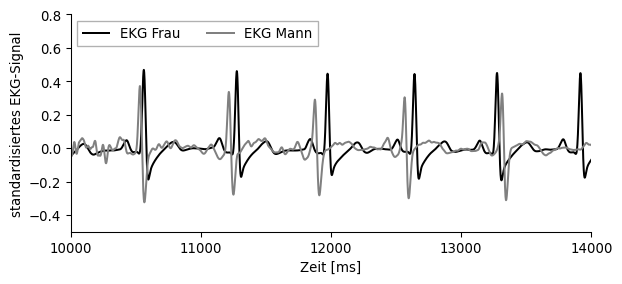

In [23]:
# Plot cleaned ECG data for a dyad
d = 4
fig = plt.figure(figsize=figsize, dpi=dpi)

plt.xlim(xlim1, xlim2)
plt.margins(x=0)
plt.ylim(-0.5, 0.8)

# plt.title("EKG-Signal einer Dyade")
plt.xlabel('Zeit [ms]')
plt.ylabel('standardisiertes EKG-Signal')

plt.plot(
    ecg[con][d],
    color="black",
    label="EKG Frau")
plt.plot(
    ecg[con][d+1],
    color="grey",
    label="EKG Mann")
plt.xticks(
    np.linspace(
        xlim1,
        xlim2,
        ((xlim2-xlim1)//sampling_rate)+1))

plt.legend(loc="upper left", ncol=2)
print(
    "Number of R-peaks in plot:",
    sum(rpeaks[con][d][xlim1:xlim2]),
    sum(rpeaks[con][d+1][xlim1:xlim2]))

sns.despine()
plt.savefig(
    "plots/ecg_dyad.png",
    bbox_inches='tight',
    dpi=512)

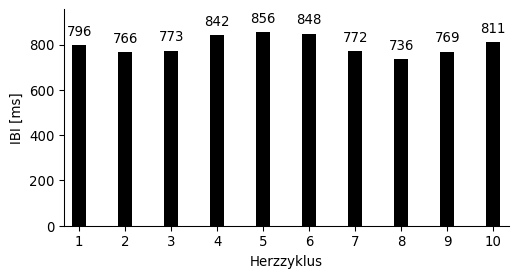

In [24]:
#  Plot tachogramm for IBI-series
ibi_plot = ibi[con][p][10:20]
fig = plt.figure(figsize=[5.5, 3], dpi=dpi)
# mpl.rcParams.update({'font.size': 11})

plt.margins(x=0.02)
plt.ylim(0, max(ibi[con][p][10:20])+100)

plt.xlabel('Herzzyklus')
plt.ylabel('IBI [ms]')
x = range(1, 11)  # label locations
plt.xticks(x)

width = 0.3  # the width of the bars
rects = plt.bar(
    x,
    ibi_plot,
    width,
    label='IBI',
    color="k")

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        plt.annotate(
            '{}'.format(height),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 5),  # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom')

autolabel(rects)
sns.despine()

fig.tight_layout()

plt.savefig(
    "plots/tachogram.png",
    bbox_inches='tight',
    dpi=512)

Number of R-peaks in plot: 354 304


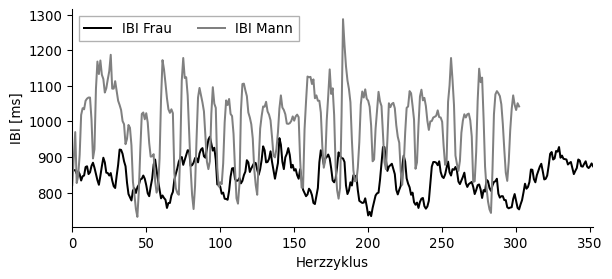

In [25]:
# Plot IBI data
d = 0
fig = plt.figure(figsize=figsize, dpi=dpi)

plt.margins(x=0)

# plt.title("IBI-Werte einer Dyade abhängig zum Herzzyklus")
plt.xlabel('Herzzyklus')
plt.ylabel('IBI [ms]')

plt.plot(
    ibi[con][d],
    color="black",
    label="IBI Frau")
plt.plot(
    ibi[con][d+1],
    color="grey",
    label="IBI Mann")
sns.despine()
plt.legend(loc="upper left", ncol=2)

print(
    "Number of R-peaks in plot:",
    sum(rpeaks[con][d]),
    sum(rpeaks[con][d+1])
)
plt.savefig(
    "plots/ibi_dyad.png",
    dpi=512, bbox_inches='tight')

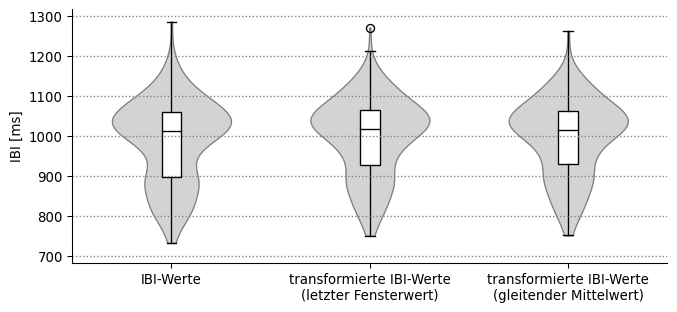

In [28]:
# Create Violin plot
con = "gaze"
level = "individual"
p = 1
ibi_dataset = {
    "all": [
        np.array(flatten(ibi[con])),
        np.array(flatten([
            ibi_ts_ip_1hz[con][i].dropna()
            for i in participants])),
        np.array(flatten([
            ibi_ts_ip_win[con][i].dropna()
            for i in participants]))],
    "individual": [
        np.array(ibi[con][p]),
        np.array(ibi_ts_ip_1hz[con][p].dropna()),
        np.array(ibi_ts_ip_win[con][p].dropna())]
}

positions = [1, 2, 3]

# Draw violin plot with box plot
fig, ax = plt.subplots(figsize=[8, 3.5], dpi=dpi)

plt.margins(y=0.03)
plt.margins(x=0.0)

# plt.title("Verteilung ursprünglicher und transformierter IBI-Werte einer Person")
plt.ylabel('IBI [ms]')

# Plot individual or all data
vp = ax.violinplot(
    dataset=ibi_dataset[level],
    positions=positions,
    vert=True, widths=0.6,
    showmeans=False, 
    showextrema=False, 
    showmedians=False)
bp = ax.boxplot(
    ibi_dataset[level],
    positions=positions,
    widths=0.1, patch_artist=True,
    medianprops=dict(color="black"))

# Add hlines
hline_max = round_to_E2(int(max(flatten(ibi_dataset[level]))))
hline_min = round_to_E2(int(min(flatten(ibi_dataset[level]))))

plt.hlines(
    y=list(range(hline_min, hline_max+100, 100)),
    xmin=0.5,
    xmax=3.5,
    colors='grey',
    ls=':', lw=1)

sns.despine()

plt.xticks(
    ticks=[1, 2, 3],
    labels=[
        "IBI-Werte",
        "transformierte IBI-Werte\n(letzter Fensterwert)",
        "transformierte IBI-Werte\n(gleitender Mittelwert)"])

for body in vp['bodies']:
    body.set_facecolor('lightgrey')
    body.set_edgecolor('grey')
    body.set_alpha(1)
for box in bp['boxes']:
    box.set(facecolor='white')

plt.savefig(
    "plots/ibi_distribution.png", 
    dpi=512, bbox_inches='tight')


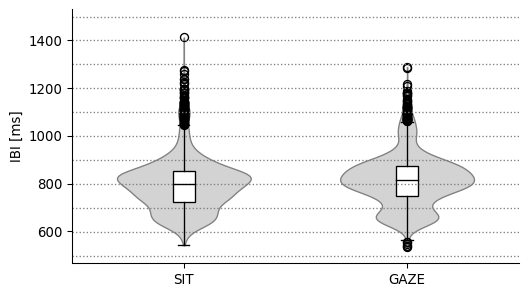

In [29]:
# Create Violin plot
rsa_dataset = []

for con in conditions:
    rsa_dataset.append(np.array(flatten(ibi[con])))

# Draw violin plot with box plot
fig, ax = plt.subplots(figsize=[6, 3.5], dpi=dpi)

plt.margins(y=0.03)
plt.margins(x=0.0)

# plt.title("Verteilung ursprünglicher und transformierter IBI-Werte einer Person")
plt.ylabel('IBI [ms]')

positions = [1, 2]
# Plot individual or all data
vp = ax.violinplot(
    dataset=rsa_dataset,
    positions=positions,
    vert=True, widths=0.6,
    showmeans=False, 
    showextrema=False, 
    showmedians=False)
bp = ax.boxplot(
    rsa_dataset,
    positions=positions,
    widths=0.1, 
    patch_artist=True,
    medianprops=dict(color="black"))

# Add hlines
hline_max = round_to_E2(int(max(flatten(rsa_dataset))))
hline_min = round_to_E2(int(min(flatten(rsa_dataset))))-2


plt.hlines(
    y=list(range(hline_min, hline_max+100, 100)),
    xmin=0.5,
    xmax=max(positions)+0.5,
    colors='grey',
    ls=':', lw=1)

sns.despine()

plt.xticks(
    ticks=positions,
    labels=["SIT","GAZE"])

for body in vp['bodies']:
    body.set_facecolor('lightgrey')
    body.set_edgecolor('grey')
    body.set_alpha(1)
for box in bp['boxes']:
    box.set(facecolor='white')

plt.savefig("plots/ibi_distribution.png", dpi=512, bbox_inches='tight')


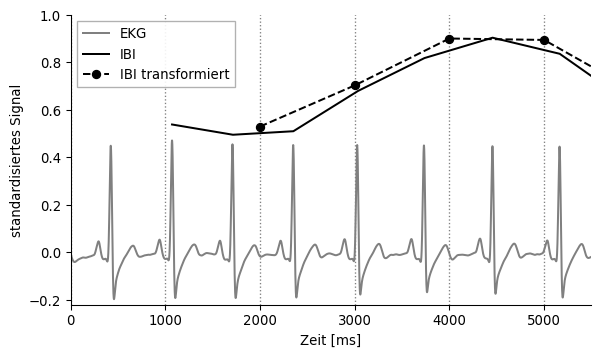

In [30]:
# Plot linear interpolated IBIs
p = 4
# Reminder: plot data with different number of datapoints for IBI and tranformed IBI
fig = plt.figure(figsize=[7, 4], dpi=dpi)

# plt.xlim(xlim1, xlim2)
plt.xlim(0, 5500)
plt.ylim(ymax=1, ymin=-0.22)
plt.margins(x=0)

# plt.title("EKG-Signal im Vergleich zu linear interpolierten IBI-Werten")
plt.xlabel('Zeit [ms]')
plt.ylabel('standardisiertes Signal')

# multiple lines all full height
plt.vlines(
    x=list(range(0, len(rpeaks[con][0]), 1000)),
    ymin=-2,
    ymax=2,
    colors='grey',
    ls=':', lw=1)
plt.plot(
    ecg[con][p],
    '-', color='grey',
    label="EKG")
plt.plot(
    get_normalized_df(ibi_ts_ip[con][p]),
    'k-', label="IBI")
plt.plot(
    get_normalized_df(ibi_ts_ip_win[con][p]),
    'k--o', label="IBI transformiert")

sns.despine()
plt.legend(loc="best", frameon=True)

plt.savefig("plots/ecg_ibi.png", dpi=512, bbox_inches='tight')


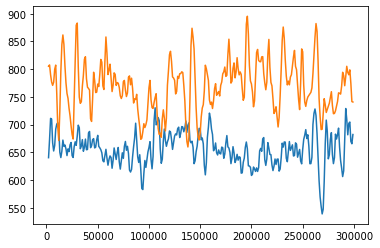

In [31]:
plt.plot(ibi_ts_ip_win[con][p].dropna())
plt.plot(ibi_ts_ip_win[con][p+1].dropna())

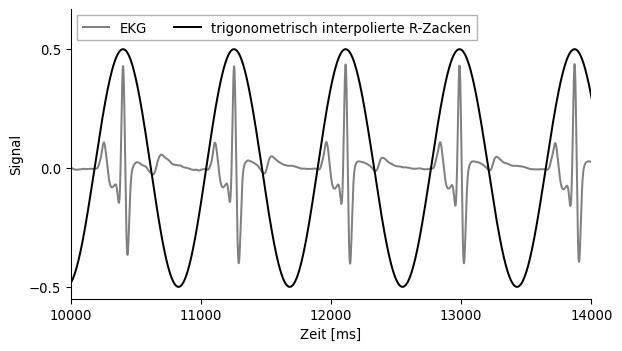

In [32]:
# Plot trigonomic interpolated R-peaks
p = 0
fig = plt.figure(figsize=[7, 4], dpi=dpi)

plt.xlim(xlim1, xlim2)
plt.xticks(np.linspace(
    xlim1, xlim2, 
    ((xlim2-xlim1)//sampling_rate)+1))
plt.margins(x=0)
plt.ylim(ymax=0.67, ymin=-0.55)
plt.yticks([-0.5, 0, 0.5])

# plt.title("EKG-Signal im Vergleich zu trigonometrisch interpolierten R-Zacken")
plt.xlabel('Zeit [ms]')
plt.ylabel('Signal')

plt.plot(
    ecg[con][p],
    "-", color='grey',
    label="EKG")
plt.plot(
    data[con][p],
    "k-",
    label="trigonometrisch interpolierte R-Zacken")

sns.despine()
plt.legend(
    loc="upper left",
    ncol=2,
    frameon=True)
# plt.legend(loc='upper center',ncol=2, bbox_to_anchor=(0.5, -0.15),frameon=False)

plt.savefig("plots/ecg_cos.png", dpi=512, bbox_inches='tight')


##### Sanity checks


762.0
1
0.5
300000
0.9999958315469445
30634.0 26428.440847398197 26433.137942532885


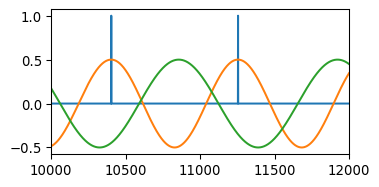

In [33]:
q = 200
print(ibi_ts[con][p][rpeaks_idx[con][p][q]])  # should be an IBI
print(rpeaks[con][p][rpeaks_idx[con][p][q]])  # should be 1
print(data[con][p][rpeaks_idx[con][p][q]])   # should be 0.5

print(len(data[con][p]))  # should be 300.000

# Comparision with data input for LSTM model (at 50 Hz)
print(
    np.corrcoef(
        data[con][p][2000:298000:20],
        np.load(f"data/data_{con}.npy")[p])[0, 1])

# Checksum for IBI and interpolated IBI
print(
    sum(ibi_ts[con][p][9000:40000]),
    sum(ibi_ts_ip_win[con][p][9:40]),
    sum(ibi_ts_ip_1hz[con][p][9:40]))

fig = plt.figure(figsize=(4, 2), dpi=96)
plt.xlim(10000, 12000)
plt.plot(rpeaks[con][p])
plt.plot(data[con][p])
if p+1 < num_participants:
    plt.plot(data[con][p+1])
